In [6]:
from pyspark.sql import SparkSession

# Start spark session
spark = SparkSession.builder \
    .appName("PCA-part") \
    .master("local[*]") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .getOrCreate()

# Load datasets
def load_test_data(debug=False):
    if debug:
        train_data = spark.read.parquet("simplified_train_data.parquet").limit(300000)
        
    else:
        train_data = spark.read.parquet("simplified_train_data.parquet")
        
    return train_data

processed_train_data = load_test_data(debug=False)

In [7]:
COMPONENTS = 3

TARGET = "attack_index" 

feature_groups = {
    "ttl": ["MIN_TTL", "MAX_TTL"],
    "tcp_flags": ["CLIENT_TCP_FLAGS", "SERVER_TCP_FLAGS", "TCP_FLAGS"],
    "flow": ["LONGEST_FLOW_PKT", "SHORTEST_FLOW_PKT"],
    "duration" : ["FLOW_DURATION_MILLISECONDS"],
    "pkt_size": ["MIN_IP_PKT_LEN", "MAX_IP_PKT_LEN"],
    "tcp_win": ["TCP_WIN_MAX_IN", "TCP_WIN_MAX_OUT"],
    "l4_dst_port": ["L4_DST_PORT"],
}

ROW_LIMIT = 100000

FEATURES = [f"scaled_{group_name}_features" for group_name in feature_groups.keys()]

In [8]:
# Perform PCA
from pyspark.ml.feature import PCA
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

final_assembler = VectorAssembler(inputCols=FEATURES, outputCol="final_features")
pca = PCA(k=COMPONENTS, inputCol="final_features", outputCol="pca_features")
pipeline = Pipeline(stages=[final_assembler, pca])


In [9]:
pca_model = pipeline.fit(processed_train_data)
pca_result = pca_model.transform(processed_train_data)

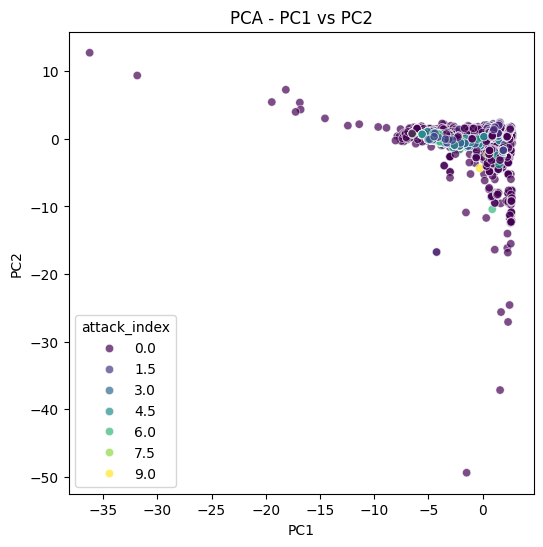

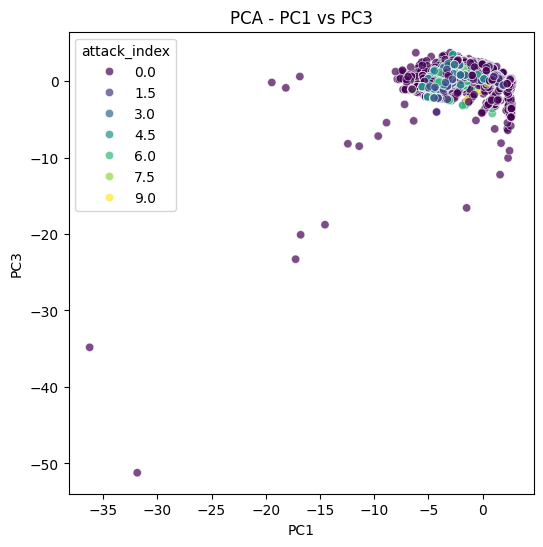

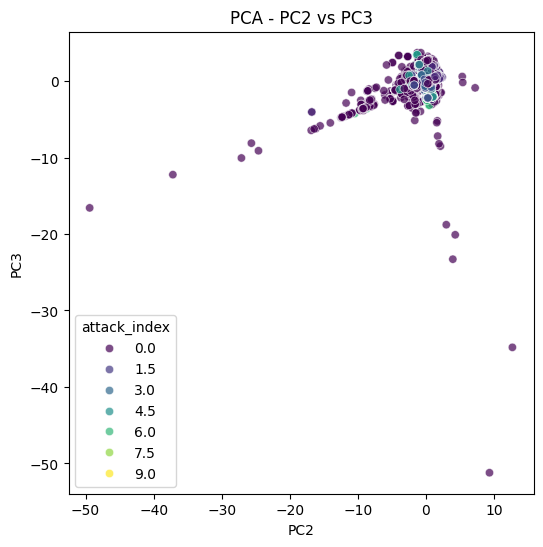

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def plot_pca_scatter(
    pca_result, target: str = TARGET, num_components: int = COMPONENTS
):

    # Convert PCA results to Pandas DataFrame for visualization
    pca_pd = pca_result.limit(ROW_LIMIT).toPandas()

    # Extract principal components into separate columns
    pca_columns = [f"PC{i+1}" for i in range(num_components)]
    pca_components = pd.DataFrame(
        pca_pd["pca_features"].apply(lambda x: x[:num_components]).tolist(),
        columns=pca_columns,
        index=pca_pd.index,
    )

    # Combine PCA components with the target variable
    pca_pd = pd.concat([pca_pd, pca_components], axis=1)

    def scatter_plot(pca_pd, x, y):
        plt.figure(figsize=(6, 6))
        sns.scatterplot(x=x, y=y, hue=target, data=pca_pd, palette="viridis", alpha=0.7)
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title(f"PCA - {x} vs {y}")
        plt.legend(title=target)
        plt.show()

    # Plot foreach pair of principal components
    for i in range(num_components):
        for j in range(i + 1, num_components):
            scatter_plot(pca_pd, pca_columns[i], pca_columns[j])


# Plot PCA results
plot_pca_scatter(pca_result)

In [11]:
def significant_features_by_pca(pca_model, features = FEATURES):    
    # Estrai il modello PCA
    pca_stage = pca_model.stages[-1]
    
    # Ottieni le componenti principali
    pca_components = pca_stage.pc.toArray()
    
    # Ottieni la varianza spiegata
    explained_variance = pca_stage.explainedVariance.toArray()
    
    # Determina le features più significative
    significant_features = {}
    for i, ev in enumerate(explained_variance):
        component = pca_components[:, i]
        # Le features significative per questa componente
        feature_contributions = {features[j]: abs(component[j]) for j in range(len(features))}
        # Ordina per contributo in ordine decrescente
        sorted_features = sorted(feature_contributions.items(), key=lambda x: x[1], reverse=True)
        significant_features[f'PC{i+1}'] = sorted_features
    
    return significant_features, explained_variance

# Esegui l'analisi PCA e determina le features più significative
significant_features, explained_variance = significant_features_by_pca(pca_model)


In [12]:
print("\nExplained variance for each principal component:")
for i, ev in enumerate(explained_variance):
    print(f"PC{i+1}: {ev:.4f}")

print("\nSum of explained variance:", explained_variance.sum())

print("\nTop 10 features for each principal component:")
for pc, features in significant_features.items():
    print(f"\n{pc}:")
    for feature, contribution in features[:10]:  # Mostra le prime 10 features per ogni componente
        print(f"{feature}: {contribution:.4f}")


Explained variance for each principal component:
PC1: 0.5459
PC2: 0.0962
PC3: 0.0903

Sum of explained variance: 0.7323725339813703

Top 10 features for each principal component:

PC1:
scaled_flow_features: 0.3461
scaled_ttl_features: 0.3267
scaled_tcp_flags_features: 0.3264
scaled_duration_features: 0.3241
scaled_pkt_size_features: 0.3093
scaled_tcp_win_features: 0.2880
scaled_l4_dst_port_features: 0.0179

PC2:
scaled_l4_dst_port_features: 0.6988
scaled_pkt_size_features: 0.2157
scaled_duration_features: 0.1238
scaled_tcp_flags_features: 0.1013
scaled_ttl_features: 0.1010
scaled_tcp_win_features: 0.0985
scaled_flow_features: 0.0960

PC3:
scaled_tcp_win_features: 0.5334
scaled_l4_dst_port_features: 0.2034
scaled_tcp_flags_features: 0.1740
scaled_ttl_features: 0.1732
scaled_pkt_size_features: 0.0944
scaled_duration_features: 0.0827
scaled_flow_features: 0.0136


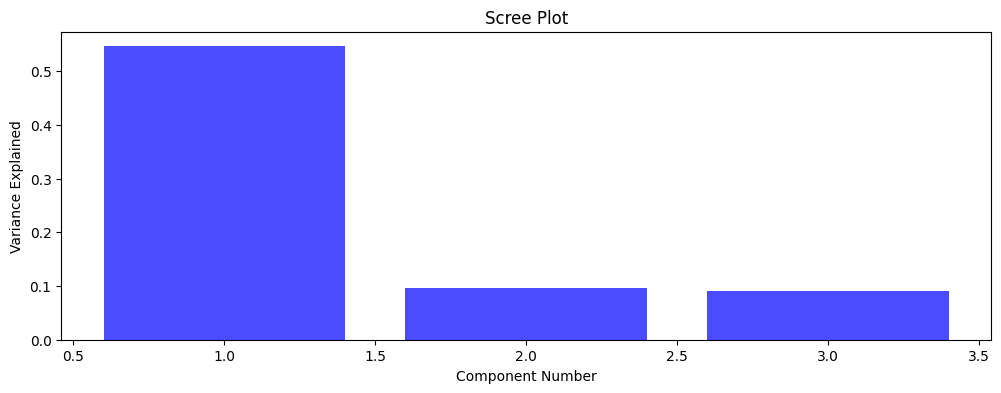

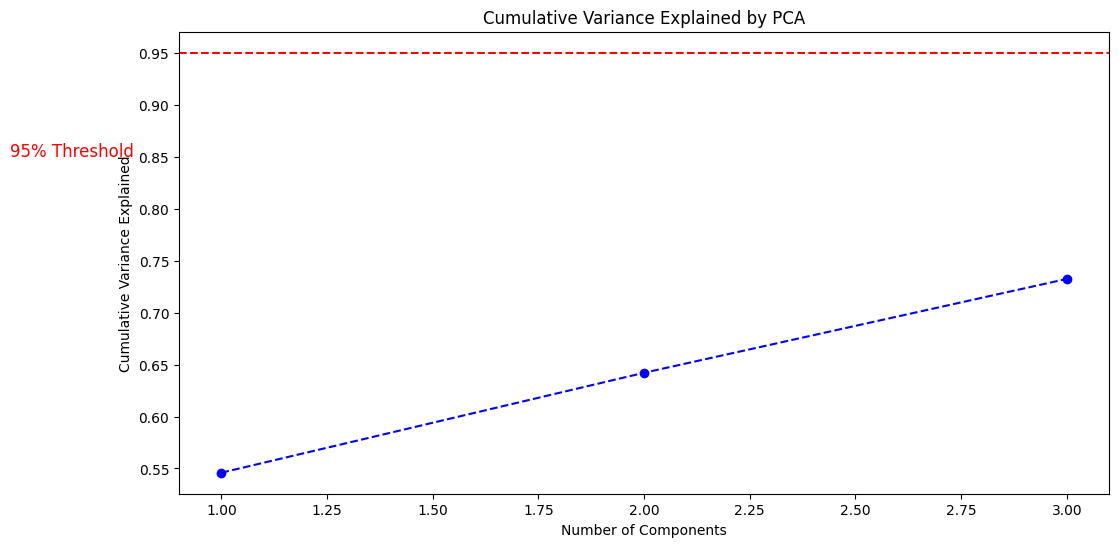

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scree(explained_variance):
    plt.figure(figsize=(12, 4))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='b', align='center')
    plt.xlabel('Component Number')
    plt.ylabel('Variance Explained')
    plt.title('Scree Plot')
    plt.show()

def plot_cumulative_variance(explained_variance):
    cumulative_variance = np.cumsum(explained_variance)
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Variance Explained')
    plt.title('Cumulative Variance Explained by PCA')
    plt.axhline(y=0.95, color='r', linestyle='--')
    plt.text(0.5, 0.85, '95% Threshold', color='red', fontsize=12)
    plt.show()

plot_scree(explained_variance)
plot_cumulative_variance(explained_variance)


In [15]:
spark.stop()